In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [2]:
def get_cleaned_data(src=None) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    if src:
        if isinstance(src, list):
            dfs = []
            for file in src:
                u_df = pd.read_csv(file)
                dfs.append(u_df)
            df = pd.concat(dfs, ignore_index=True)
        else:
            df = pd.read_csv(src)
    else:
        urls = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_2.csv']
        dfs = []
        for url in urls:
            u_df = pd.read_csv(url)
            dfs.append(u_df)
        df = pd.concat(dfs, ignore_index=True)
    
    # Filter the data
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_value','instant_bookable', 'license']
                        ][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['host_since'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['room_type'] != 'Hotel room')
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # fill NA data for reviews with 0s
    working_sample['review_scores_value'].fillna(0, inplace=True)
    
    # fill NA data for bedrooms with 1s
    working_sample['bedrooms'].fillna(1, inplace=True)
    
    # fill NA data for license with NAN
    working_sample['license'].fillna('NAN', inplace=True)
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_has_license'] = working_sample['license'].apply(lambda x: 1 if x != 'NAN' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2023-03-31') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # clean the property type and room type
    working_sample['property_type'] = working_sample['property_type'].apply(lambda x: x.lower().replace('entire ', '').replace('private room ', '').replace('shared room ', '').replace('room in ', '').replace('in ', ''))
    working_sample['room_type'] = working_sample['room_type'].apply(lambda x: x.lower())
    
    # add amenities columns
    working_sample['d_entertainment'] = working_sample['amenities'].apply(lambda x: 1 if 'tv' in x.lower() or 'game' in x.lower() or 'roku' in x.lower() or 'disney' in x.lower() or 'netflix' in x.lower() or 'nintendo' in x.lower() or'chromecast' in x.lower() or 'alexa' in x.lower() or 'sound' in x.lower() else 0)
    working_sample['d_wifi'] = working_sample['amenities'].apply(lambda x: 1 if 'wifi' in x.lower() else 0)
    working_sample['d_kitchenware'] = working_sample['amenities'].apply(lambda x: 1 if 'fridge' in x.lower() or 'freezer' in x.lower() or 'stove' in x.lower() or 'coffee' in x.lower() or 'oven' in x.lower() or 'blender' in x.lower() or 'grill' in x.lower() or 'dishwasher' in x.lower() else 0)
    working_sample['d_washer'] = working_sample['amenities'].apply(lambda x: 1 if ('washer' in x.lower() or 'dryer' in x.lower() or 'drying' in x.lower()) else 0)
    working_sample['d_sauna_hot_tub'] = working_sample['amenities'].apply(lambda x: 1 if 'sauna' in x.lower() or 'tub' in x.lower() else 0)
    working_sample['d_pool'] = working_sample['amenities'].apply(lambda x: 1 if ' pool' in x.lower() or 'Pool' in x else 0)
    working_sample['d_aircon'] = working_sample['amenities'].apply(lambda x: 1 if 'air con' in x.lower() else 0)
    working_sample['d_heating'] = working_sample['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
    working_sample['d_scenic_view_access'] = working_sample['amenities'].apply(lambda x: 1 if 'view' in x.lower() or 'access' in x.lower() else 0)
    working_sample['d_parking'] = working_sample['amenities'].apply(lambda x: 1 if 'parking' in x.lower() or 'carport' in x.lower() else 0)
    working_sample['d_pets_allowed'] = working_sample['amenities'].apply(lambda x: 1 if 'pets allowed' in x.lower() else 0)
    working_sample['d_patio_balcony'] = working_sample['amenities'].apply(lambda x: 1 if 'patio' in x.lower() or 'balcony' in x.lower() else 0)
    working_sample['d_bodyshower'] = working_sample['amenities'].apply(lambda x: 1 if 'shampoo' in x.lower() or 'conditioner' in x.lower() or 'soap' in x.lower() or 'gel' in x.lower() else 0)
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'bedrooms': 'n_bedrooms',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type',
        'review_scores_value': 'n_review_scores_value',
        'number_of_reviews': 'n_number_of_reviews'
    }, inplace=True)
    
    del df
        
    return working_sample

In [3]:
# get the working df
# work_df = get_cleaned_data(['listings_1.csv', 'listings_2.csv'])
work_df = get_cleaned_data()
work_df.shape

(16240, 44)

In [4]:
# create the list of categorical and numerical column names
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [5]:
# build interaction terms
interactions = []
for i in categorical_columns + numerical_columns:
    for k in categorical_columns + numerical_columns:
        if i == k or i+'*'+k in interactions or k+'*'+i in interactions:
            continue
        else:
            interactions.append(i + '*' + k)

In [6]:
# define function to get train test split for OLS and LASSO
def get_ols_train_test_split(data, lasso=False):
    if lasso:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data, return_type="dataframe")
    else:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns), data, return_type="dataframe")
    ols_terms_list = ols_df.design_info.column_names
    ols_df['price'] = y_
    ols_data_train, ols_data_holdout = train_test_split(ols_df, train_size=0.7, random_state=42)
    return ols_data_train, ols_data_holdout, ols_terms_list

In [7]:
# split the data for ensemble algorithms
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((11368, 44), (4872, 44))

Simple OLS

In [8]:
# build and train the OLS model
ols_data_train, ols_data_holdout, ols_terms_list = get_ols_train_test_split(work_df)

start_time = datetime.now()
ols_model = LinearRegression().fit(ols_data_train[ols_terms_list], ols_data_train['price'])
ols_time = datetime.now() - start_time
ols_model

LinearRegression()

In [9]:
ols_rmse = mean_squared_error(ols_model.predict(ols_data_train.drop(columns=['price'])), ols_data_train['price'], squared=False)
ols_rmse;

In [10]:
# get the coefficients of the OLS
df_ols_var_coefs = pd.DataFrame(
    ols_model.coef_.tolist(),
    index=ols_terms_list,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3)).loc[
    lambda x: x.ols_coefficient != 0
]
df_ols_var_coefs['abs_ols_coefficient'] = df_ols_var_coefs["ols_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
df_ols_var_coefs = df_ols_var_coefs.reset_index().rename(columns={'index': 'term'})
df_ols_var_coefs['grouped_term'] = df_ols_var_coefs['term'].apply(lambda x: x.split('[')[0])
# df_ols_var_coefs.sort_values(by="abs_ols_coefficient", ascending=False).iloc[:100]
df_ols_var_coefs.groupby(['grouped_term']).sum().sort_values(by="abs_ols_coefficient", ascending=False)[['ols_coefficient', 'abs_ols_coefficient']].iloc[:10];

LASSO

In [11]:
# get the matrices for LASSO
def get_lasso_matrices(data):
    y_ = data['price']
    X_ = data[lasso_terms_list]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    return y_, X_

In [12]:
# get lasso data split
lasso_data_train, lasso_data_holdout, lasso_terms_list = get_ols_train_test_split(work_df, lasso=True)

# define model
lasso_model = ElasticNet(l1_ratio = 1, fit_intercept = True)

# define cv search
lasso_search = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(10, 55, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# perform the search
y, X = get_lasso_matrices(lasso_data_train)

start_time = datetime.now()
lasso_results = lasso_search.fit(X, y)
lasso_time = datetime.now() - start_time

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......................alpha=0.1;, score=-48.937 total time=  10.5s
[CV 2/5] END .......................alpha=0.1;, score=-44.724 total time=   9.1s
[CV 3/5] END .......................alpha=0.1;, score=-44.196 total time=  13.4s
[CV 4/5] END .......................alpha=0.1;, score=-44.379 total time=  12.1s
[CV 5/5] END .......................alpha=0.1;, score=-44.096 total time=  17.1s
[CV 1/5] END ......................alpha=0.15;, score=-47.701 total time=   7.1s
[CV 2/5] END ......................alpha=0.15;, score=-43.498 total time=   5.7s
[CV 3/5] END ......................alpha=0.15;, score=-43.656 total time=   8.5s
[CV 4/5] END ......................alpha=0.15;, score=-44.225 total time=   7.9s
[CV 5/5] END ......................alpha=0.15;, score=-43.771 total time=   6.6s
[CV 1/5] END .......................alpha=0.2;, score=-46.657 total time=   5.7s
[CV 2/5] END .......................alpha=0.2;, s

In [13]:
lasso_results.best_estimator_

ElasticNet(alpha=0.4, l1_ratio=1)

In [14]:
# get the coefficients of the LASSO
df_lasso_var_coefs = pd.DataFrame(
    lasso_results.best_estimator_.coef_.tolist(),
    index=lasso_terms_list,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]
df_lasso_var_coefs['abs_lasso_coefficient'] = df_lasso_var_coefs["lasso_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
# df_lasso_var_coefs.sort_values(by="abs_lasso_coefficient", ascending=False).iloc[:30]
df_lasso_var_coefs = df_lasso_var_coefs.reset_index().rename(columns={'index': 'term'})
df_lasso_var_coefs['grouped_term'] = df_lasso_var_coefs['term'].apply(lambda x: x.split(':')[0].split('[')[0] + ':' + x.split(':')[1].split('[')[0] if ':' in x else x.split('[')[0])
df_lasso_grouped_var_coefs = df_lasso_var_coefs.groupby(['grouped_term']).sum()
df_lasso_grouped_var_coefs = df_lasso_grouped_var_coefs.reset_index()

In [15]:
# single term coef power 
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':')) == False].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10];

In [16]:
# interaction coef power
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':'))].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10];

Random Forest

In [17]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [18]:
# build search for RF
tune_grid = {"max_features": [8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 42)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [19]:
# create RF pipeline
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_random)], verbose=True
)

In [20]:
# train the RF
start_time = datetime.now()
rf_model = rf_pipe.fit(data_train[numerical_columns + categorical_columns], data_train['price'])
rf_time = datetime.now() - start_time
rf_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_leaf=5;, score=-44.817 total time=   0.5s
[CV 2/5] END max_features=8, min_samples_leaf=5;, score=-41.931 total time=   0.5s
[CV 3/5] END max_features=8, min_samples_leaf=5;, score=-42.389 total time=   0.5s
[CV 4/5] END max_features=8, min_samples_leaf=5;, score=-43.550 total time=   0.5s
[CV 5/5] END max_features=8, min_samples_leaf=5;, score=-44.470 total time=   0.5s
[CV 1/5] END max_features=8, min_samples_leaf=10;, score=-45.502 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_leaf=10;, score=-43.064 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_leaf=10;, score=-43.341 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_leaf=10;, score=-44.779 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_leaf=10;, score=-45.480 total time=   0.4s
[CV 1/5] END max_features=8, min_s

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_host_total_listings_count',
                                                   'n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_ho...
                                                   'd_sauna_hot_tub', 'd_pool',
                                                   'd_aircon', 'd_heating',
                                                   'd_scenic_view_access',
                                                   'd_parking',
                                                   'd_pets_allowed',
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [21]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1;

In [22]:
rf_random.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

Boosting

In [23]:
# build search for GBM
gbm = GradientBoostingRegressor(learning_rate=0.01, random_state = 42)

tune_grid = {"n_estimators": [200, 300, 500], "max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [8, 10, 12], 'min_samples_split': [10, 20, 30]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# build pipeline for GBM
gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [24]:
# train the GBM
start_time = datetime.now()
gbm_model = gbm_pipe.fit(data_train[numerical_columns + categorical_columns],data_train.price)
gbm_time = datetime.now() - start_time
gbm_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 5/5; 1/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 5/5; 1/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-46.669 total time=   0.8s
[CV 5/5; 2/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 5/5; 2/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=300;, score=-45.250 total time=   1.3s
[CV 2/5; 4/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 2/5; 4/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=-44.562 total time=   0.9s
[CV 3/5; 5/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_host_total_listings_count',
                                                   'n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_ho...
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 20, 30],
                                          'n_estimators': [200, 300, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [25]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=12,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

In [26]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results;

Diagnostic

RF

In [27]:
# predict with the holdout set and calculate the variable importance for RF
rf_result = permutation_importance(
    rf_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
rf_result;

In [28]:
df_rf_grouped_var_imp = (pd.DataFrame(
        rf_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_rf_grouped_var_imp['cumulative_imp'] = df_rf_grouped_var_imp.imp.cumsum()
df_rf_grouped_var_imp;

In [29]:
# predict with the holdout set and calculate the variable importance for GBM
gbm_result = permutation_importance(
    gbm_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
gbm_result;

In [30]:
df_gbm_grouped_var_imp = (pd.DataFrame(
        gbm_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_gbm_grouped_var_imp['cumulative_imp'] = df_gbm_grouped_var_imp.imp.cumsum()
df_gbm_grouped_var_imp;

RMSE training and testing

In [31]:
# build the performance summary table
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

lasso_y_holdout, lasso_X_holdout = get_lasso_matrices(lasso_data_holdout)
diagnostic_df = pd.DataFrame({'Model': ['Simple OLS', 'LASSO', 'Random Forest', 'GBM'],
                              'Train RMSE': ['{:.4f}'.format(ols_rmse), '{:.4f}'.format(lasso_search.best_score_*-1), '{:.4f}'.format(rf_random.best_score_*-1), '{:.4f}'.format(gbm_model_cv.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(ols_model.predict(ols_data_holdout.drop(columns=['price'])), ols_data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(lasso_search.predict(lasso_X_holdout), lasso_y_holdout, squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(rf_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(gbm_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False))],
                              'Training time': [get_time_delta(ols_time), get_time_delta(lasso_time), get_time_delta(rf_time), get_time_delta(gbm_time)]
                              })
diagnostic_df;

<p style="page-break-after:always;"></p>

## <center>Pricing Airbnb Apartments in Sicily, Italy</center>

### Introduction and Goal
This report investigates and explores the predictive models for forecasting Airbnb apartment prices in the top most populated and touristic cities in Sicily, Italy. The findings and models in this report will provide significant insights and help our client to price and operate small and middle-sized apartments hosting 2-6 guests. From the results, we will analyze and recommend the best model the client should use to price their company apartments. Since our client does not provide detailed information about the exact city and the rental purpose, this report will assume and focus on the most popular use case: leisure rentals in famous touristic cities in Sicily.

The code and both reports can be found on this [GitHub](https://github.com/viethngn/Data_Analysis_3_ECBS5171/tree/main/assignment2).

-----

### 1. Data

#### Data Preparation
The data in the report is the listing details of Sicily Airbnb apartments in March 2023 from http://insideairbnb.com/get-the-data/. Further data cleaning and filtering are applied to fit with our scope of analysis. The detailed steps are as follows:
1. Get the raw dataset (N = 51,679)
2. Apply filters (N = 16,240):
    - Drop observations with missing value in price, number of beds, number of bathrooms, the apartment is instant bookable.
    - Exclude apartment type 'Hotel' as our client is not operating hotel rooms.
    - Only keep apartments accommodating for 2-6 guests.
    - Only keep apartments located in Palermo, Catania, Messina, Taormina, Realmonte, Agrigento, Siracusa, Cefal, Monreale, Ragusa and Modica.
    - Exclude some extreme price values (top 1%) by keeping observation with price <= $400.
3. Feature engineering (N = 16,240):
    - Fill 0s as values for observations with no rating values.
    - Fill 1s as values for observations with no bedrooms values as these are studios.
    - Fill 'NAN' as values for observations with no license values.
    - Create boolean values for super host, the host has a profile picture, host identity verified, the apartment is instantly bookable and the host has a license.
    - Convert listing duration from text to number of days before 31/03/2023.
    - Convert price from text to numerical values.
    - Derive the number of bathrooms from the bathroom text descriptions.
    - Clean the property type to remove the redundant values of room type.
    - Derive various boolean variables for amenities from the amenities text descriptions.

From all the data features in the raw dataset, we will use a subset of those as predictors with the following rationales:
- Profile photo, verification status, license and the number of listings may influence the price as a host without those can price be lower to attract guests.
- Room details (location, type of property and room, number of accommodations, bedrooms, bathrooms, reviews, amenities, instant bookable, number of allowed nights) are chosen as rooms with higher value in any of those features can demand higher prices from intuition.
- Other features are excluded as they are presented in other predictors (like longitude) or are irrelevant to our scope.

#### Data Exploration

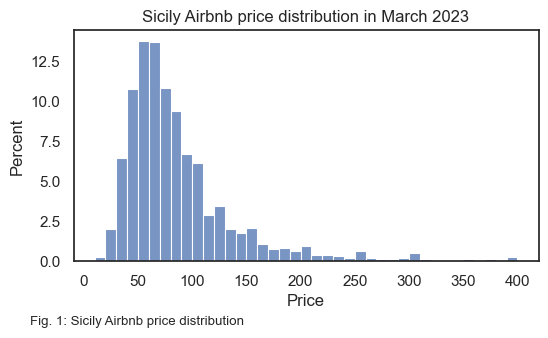

In [66]:
sns.set(style="white")
price_plot, ax3 = plt.subplots(figsize=(6,3))
price_fig = sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)
price_fig.set(title='Sicily Airbnb price distribution in March 2023', xlabel="Price")
ax3.text(-50, -4, 'Fig. 1: Sicily Airbnb price distribution', size=9.5)
price_plot.show()

From Fig. 1, it is clear that the price distribution is left-skewed. This means that the mean value price is not the typical value. Within this paper, the OLS models will assume that the mean is typical and will predict the mean value. It is worth noting that normally this is not the case and there might be impacts on the prediction results made by the OLS models.

### 2. Models
In this report, we will build 4 different models:
- Simple OLS model (OLS)
- Linear model with LASSO (LASSO)
- Random forest model (RF)
- Boosting with gradient descent model (GBM)

All models use the same set of features as discussed in the **Data** section, with the LASSO using all possible combinations of interaction terms. Since LASSO shrinks the coefficients for us and we do not know the interaction among the predictors from intuition, including all the interaction terms and letting the algorithm run will leave us with a prediction model with the optimal choice of interactions through cross-validation. Furthermore, all models, except for the simple OLS, will go through a 5-fold cross-validation with different tuning parameters to optimize for overfitting.

The data used to train and validate is the same across all models. In this report, we will split the working data (N = 16,240) into the training set and the holdout set with a ratio of 7:3.

**Simple OLS**

This model is a linear model with predictors as the features selected in the **Data** section. No interaction terms are included

**LASSO**

This linear model has predictors like the Simple OLS models but includes all possible combinations of interaction terms. The tuning parameter is the penalty term $\alpha$ in the range of [0.1, 0.5] inclusive, incremented by 0.05.

**Random Forest**

The random forest model includes all the selected features with no interaction as the random forest algorithm already handles the interactions among predictors. The tuning parameters are:
- Maximum number of features for each split: [8, 10, 12]
- Minimum number of samples in each terminal node: [5, 10, 15]

**Boosting with Gradient Descent**

The boosting model includes features similar to the random forest model. The tuning parameters are:
- Learning rate: 0.01
- Number of estimators: [200, 300, 500], 
- Maximum tree depth: [5, 10, 15], 
- Maximum number of features for each split: [5, 10, 15], 
- Maximum number of features for each split: [8, 10, 12], 
- Minimum number of samples to continue splitting: [10, 20, 30]
-----

### 3. Model evaluation

#### Performances
The performance result of each model are as follows:

In [33]:
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Simple OLS,44.3212,45.0548,0m0s
1,LASSO,43.8334,44.6018,4m28s
2,Random Forest,42.9022,43.2020,0m23s
3,GBM,40.1745,40.6951,7m36s


The simple OLS model RMSE is the worst of all models, but it is not significantly worse than the LASSO model. Considering that the simple OLS completes almost instantly compared to the LASSO, the simple OLS might be better if speed is the top priority. However, the Random Forest model gives better results than the simple OLS while only taking under half a minute to complete might be a more balanced choice between accuracy and speed. The GBM model has the best accuracy and is significantly better than the rest of the models, but it also takes significantly more time to finish. If accuracy is the top priority, the GBM model is the best model to go forward. The LASSO, Random Forest and GBM models are cross-validated to prevent overfitting and they perform relatively well with the holdout set compared to that over the training set. The same can be said for the simple OLS model while it has not been cross-validated.

#### Diagnostic

From our analysis of the OLS and LASSO models' coefficients (discussed in more details in the **Model evaluation** in the technical report), these variables and their interactions consistently have significant power to the change in price prediction:
- Property type (f_property_type)
- Neighbourhood (f_neighbourhood_cleansed)
- Room type (f_room_type)
- Has pool (d_pool)
- Number of bathrooms (n_bathrooms)
- Number of bedrooms (n_bedrooms)
- Number of accommodates (n_accommodates)

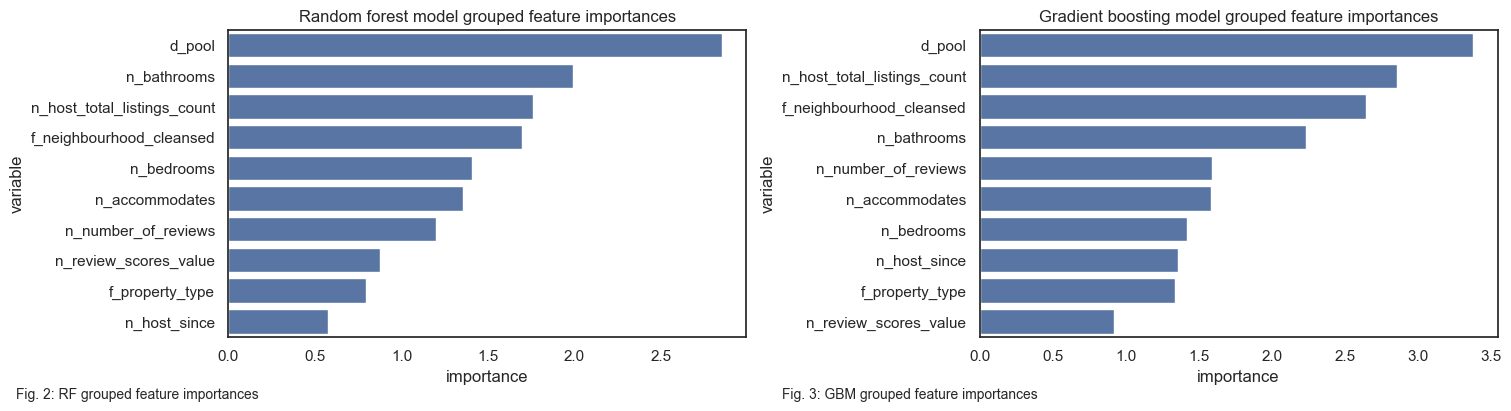

In [69]:
df_rf_grouped_var_imp = df_rf_grouped_var_imp.sort_values(by='imp', ascending=False)
df_gbm_grouped_var_imp = df_gbm_grouped_var_imp.sort_values(by='imp', ascending=False)
diag_fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), layout="constrained")
sns.set(style="white")
rf_fig = sns.barplot(
    data = df_rf_grouped_var_imp.iloc[0:10],
    x="imp", y="variable", ax=ax1)
rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
ax1.text(-1.225, 11.5, 'Fig. 2: RF grouped feature importances', size=10)
gbm_fig = sns.barplot(
    data = df_gbm_grouped_var_imp.iloc[0:10],
    x="imp", y="variable", ax=ax2)
gbm_fig.set(title='Gradient boosting model grouped feature importances', xlabel="importance", ylabel="variable")
ax2.text(-1.35, 11.5, 'Fig. 3: GBM grouped feature importances', size=10)
diag_fig.show()

Figure 2 and Figure 3 also show the important features that impact the price prediction in the Random Forest and GBM models. The significant terms in the simple OLS and LASSO models are also important here. However, the Random Forest and GBM models have a few extra important predictors:
- Total number of listings that the host has (n_host_total_listings_count)
- Number of reviews (n_number_of_reviews)
- Review score (n_review_scores_value)
- Host operating duration (n_host_since)

From the feature importance analysis above, our client should provide the key information accurately for their apartment to get a good price prediction. Since our client's apartments are all new, the number of reviews and review scores may not be available. Thus, both of these values should be set at 0.

-----

### 4. Conclusion
The choice of model is pivotal to support our client price their new apartments, as each offers unique advantages. In this report, the simple OLS and Random Forest models offer simplicity and speed, while the LASSO and GBM models offer accuracy with a trade-off in complexity. Among the evaluated models—Simple OLS, LASSO, Random Forest, and GBM—the GBM model excelled in accuracy over the rest. However, due to its computational demands, we might want to recommend the Random Forest to be the model of choice as it balances the complexity and usability.

<p style="page-break-after:always;"></p>

## <center>Pricing Airbnb Apartments in Sicily, Italy - Technical Report</center>

The code and both reports can be found on this [GitHub](https://github.com/viethngn/Data_Analysis_3_ECBS5171/tree/main/assignment2).

### 1. Data
As described in the summary report, we have to do some file manipulation and feature engineering to obtain the necessary predictors.

For file manipulation, since the original data file is too large, GitHub refuses to accept the file. Hence, we have to split the file into 2 parts and read into 2 dataframes. The final working dataframe is the concatenation of those 2 dataframes.

When applying filters, we decided to drop the observations with missing values as they only cover a very small amount of the observations. Also, aside from the business reasons, we limit the dataset to popular cities otherwise the data set remains too large and take time to run the ML models.

During the feature engineering steps, some decisions are taken when imputing values. We fill 1s as values for observations with no bedrooms values as upon spot checking, these are studio apartments. We also convert listing duration from text to number of days before 31/03/2023 because the data is collected for observation up until 31/03/2023. Values may change after that period hence we use the cut-off date as 31/03/2023 to ensure correctness.

In [37]:
def get_cleaned_data(src=None) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    if src:
        if isinstance(src, list):
            dfs = []
            for file in src:
                u_df = pd.read_csv(file)
                dfs.append(u_df)
            df = pd.concat(dfs, ignore_index=True)
        else:
            df = pd.read_csv(src)
    else:
        urls = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_2.csv']
        dfs = []
        for url in urls:
            u_df = pd.read_csv(url)
            dfs.append(u_df)
        df = pd.concat(dfs, ignore_index=True)
    
    # Filter the data
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_value','instant_bookable', 'license']
                        ][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['host_since'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['room_type'] != 'Hotel room')
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # fill NA data for reviews with 0s
    working_sample['review_scores_value'].fillna(0, inplace=True)
    
    # fill NA data for bedrooms with 1s
    working_sample['bedrooms'].fillna(1, inplace=True)
    
    # fill NA data for license with NAN
    working_sample['license'].fillna('NAN', inplace=True)
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_has_license'] = working_sample['license'].apply(lambda x: 1 if x != 'NAN' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2023-03-31') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # clean the property type and room type
    working_sample['property_type'] = working_sample['property_type'].apply(lambda x: x.lower().replace('entire ', '').replace('private room ', '').replace('shared room ', '').replace('room in ', '').replace('in ', ''))
    working_sample['room_type'] = working_sample['room_type'].apply(lambda x: x.lower())
    
    # add amenities columns
    working_sample['d_entertainment'] = working_sample['amenities'].apply(lambda x: 1 if 'tv' in x.lower() or 'game' in x.lower() or 'roku' in x.lower() or 'disney' in x.lower() or 'netflix' in x.lower() or 'nintendo' in x.lower() or'chromecast' in x.lower() or 'alexa' in x.lower() or 'sound' in x.lower() else 0)
    working_sample['d_wifi'] = working_sample['amenities'].apply(lambda x: 1 if 'wifi' in x.lower() else 0)
    working_sample['d_kitchenware'] = working_sample['amenities'].apply(lambda x: 1 if 'fridge' in x.lower() or 'freezer' in x.lower() or 'stove' in x.lower() or 'coffee' in x.lower() or 'oven' in x.lower() or 'blender' in x.lower() or 'grill' in x.lower() or 'dishwasher' in x.lower() else 0)
    working_sample['d_washer'] = working_sample['amenities'].apply(lambda x: 1 if ('washer' in x.lower() or 'dryer' in x.lower() or 'drying' in x.lower()) else 0)
    working_sample['d_sauna_hot_tub'] = working_sample['amenities'].apply(lambda x: 1 if 'sauna' in x.lower() or 'tub' in x.lower() else 0)
    working_sample['d_pool'] = working_sample['amenities'].apply(lambda x: 1 if ' pool' in x.lower() or 'Pool' in x else 0)
    working_sample['d_aircon'] = working_sample['amenities'].apply(lambda x: 1 if 'air con' in x.lower() else 0)
    working_sample['d_heating'] = working_sample['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
    working_sample['d_scenic_view_access'] = working_sample['amenities'].apply(lambda x: 1 if 'view' in x.lower() or 'access' in x.lower() else 0)
    working_sample['d_parking'] = working_sample['amenities'].apply(lambda x: 1 if 'parking' in x.lower() or 'carport' in x.lower() else 0)
    working_sample['d_pets_allowed'] = working_sample['amenities'].apply(lambda x: 1 if 'pets allowed' in x.lower() else 0)
    working_sample['d_patio_balcony'] = working_sample['amenities'].apply(lambda x: 1 if 'patio' in x.lower() or 'balcony' in x.lower() else 0)
    working_sample['d_bodyshower'] = working_sample['amenities'].apply(lambda x: 1 if 'shampoo' in x.lower() or 'conditioner' in x.lower() or 'soap' in x.lower() or 'gel' in x.lower() else 0)
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'bedrooms': 'n_bedrooms',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type',
        'review_scores_value': 'n_review_scores_value',
        'number_of_reviews': 'n_number_of_reviews'
    }, inplace=True)
    
    del df
    if not src or isinstance(src, list):
        del dfs[0]
        del dfs[1]
        
    return working_sample

-----
### 2. Model Construction

#### OLS and LASSO
For OLS and LASSO models, we use the patsy.dmatrices() method to create the matrices for training with the training set and diagnostic on the holdout set to handle the interaction terms.


In [38]:
# define function to get train test split for OLS and LASSO
def get_ols_train_test_split(data, lasso=False):
    if lasso:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data, return_type="dataframe")
    else:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns), data, return_type="dataframe")
    ols_terms_list = ols_df.design_info.column_names
    ols_df['price'] = y_
    ols_data_train, ols_data_holdout = train_test_split(ols_df, train_size=0.7, random_state=42)
    return ols_data_train, ols_data_holdout, ols_terms_list

With the LASSO model, we have to write another function to standardize the values in the matrices. This function is reused when making prediction with the holdout set.

In [39]:
# get the matrices for LASSO
def get_lasso_matrices(data):
    y_ = data['price']
    X_ = data[lasso_terms_list]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    return y_, X_

In [40]:
ols_model

LinearRegression()

In [41]:
lasso_results.best_estimator_

ElasticNet(alpha=0.4, l1_ratio=1)

#### Random Forest and GBM
For the Random Forest and GBM models, we use the scikit-learn OneHotEncoder() to create the dummy values for categorical predictors. We also use the scikit-learn pipeline for both of these models instead of patsy.dmatrices() as it will handle the data transformer automatically. The defined data preprocessing step is reused in both Random Forest and GBM pipelines.

In [42]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [43]:
lasso_results.best_estimator_

ElasticNet(alpha=0.4, l1_ratio=1)

In [44]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=12,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

-----

### 3. Model evaluation

#### Diagnostic

In [34]:
plt_ols_grouped_coef = df_ols_var_coefs.groupby(['grouped_term']).sum().sort_values(by="abs_ols_coefficient", ascending=False)[['ols_coefficient', 'abs_ols_coefficient']].iloc[:10]
plt_ols_grouped_coef.reset_index(inplace=True)
plt_ols_grouped_coef

,grouped_term,ols_coefficient,abs_ols_coefficient
0,f_property_type,-1416.989,1738.185
1,f_neighbourhood_cleansed,3.327,118.913
2,f_room_type,-47.871,47.871
3,d_pool,36.514,36.514
4,n_bathrooms,18.799,18.799
5,n_bedrooms,11.076,11.076
6,d_sauna_hot_tub,10.713,10.713
7,d_wifi,10.306,10.306
8,d_pets_allowed,-5.712,5.712
9,n_accommodates,5.410,5.410


<sup>Table 1: Simple OLS grouped term coefficients</sub>

In [35]:
df_lasso_grouped_var_coefs.sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10]

,grouped_term,lasso_coefficient,abs_lasso_coefficient
48,f_neighbourhood_cleansed:f_property_type,4.394,17.616
100,n_accommodates:n_bathrooms,7.549,7.549
72,f_property_type:d_pool,2.708,6.722
67,f_property_type:d_instant_bookable,1.538,5.814
73,f_property_type:d_sauna_hot_tub,4.499,5.609
91,f_room_type:n_bathrooms,-5.363,5.363
83,f_property_type:n_host_total_listings_count,3.692,5.358
101,n_accommodates:n_bedrooms,4.536,4.536
150,n_review_scores_value,-4.481,4.481
43,f_neighbourhood_cleansed:d_pool,-2.898,4.204


<sup>Table 2: LASSO grouped term coefficients (independent terms only)</sub>

In Table 1 and Table 2, the 'abs_lasso_coefficient' column is the sum of all absolute coefficient values of the categorical and interaction predictors for the simple OLS and LASSO models. This is to display how much power these terms have in determining the price. The values from 'abs_lasso_coefficient' column are the basis for the argument about the OLS and LASSO models' feature importance in the **Model evaluation** in the summary report.

#### Performance
To build the performance summary table, we create a dataframe consisting of the RMSEs from both the training set and holdout set with tracked runtime for all models.

In [45]:
# build the performance summary table
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

lasso_y_holdout, lasso_X_holdout = get_lasso_matrices(lasso_data_holdout)
diagnostic_df = pd.DataFrame({'Model': ['Simple OLS', 'LASSO', 'Random Forest', 'GBM'],
                              'Train RMSE': ['{:.4f}'.format(ols_rmse), '{:.4f}'.format(lasso_search.best_score_*-1), '{:.4f}'.format(rf_random.best_score_*-1), '{:.4f}'.format(gbm_model_cv.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(ols_model.predict(ols_data_holdout.drop(columns=['price'])), ols_data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(lasso_search.predict(lasso_X_holdout), lasso_y_holdout, squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(rf_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(gbm_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False))],
                              'Training time': [get_time_delta(ols_time), get_time_delta(lasso_time), get_time_delta(rf_time), get_time_delta(gbm_time)]
                              })
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Simple OLS,44.3212,45.0548,0m0s
1,LASSO,43.8334,44.6018,4m28s
2,Random Forest,42.9022,43.2020,0m23s
3,GBM,40.1745,40.6951,7m36s


The detailed cross-validated training performances for each model (except OLS since there is no cross-validation) are as follows:

**LASSO**

In [46]:
df_lasso_model_cv_results = pd.DataFrame(lasso_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]
df_lasso_model_cv_results.columns = ['alpha', 'rank', 'fit time', 'RMSE']
df_lasso_model_cv_results

,alpha,rank,fit time,RMSE
0,0.1,9,12.424075,-45.266518
1,0.15,8,7.153259,-44.570358
2,0.2,7,5.442965,-44.206283
3,0.25,6,5.172487,-44.017477
4,0.3,5,4.416456,-43.909048
5,0.35,4,3.556646,-43.855604
6,0.4,1,2.899762,-43.833404
7,0.45,2,2.516872,-43.833573
8,0.5,3,2.378954,-43.852494


**Random Forest**

In [47]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
8,43.43,44.43,44.98
10,43.12,44.09,44.66
12,42.90,43.75,44.32


**GBM**

In [48]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results

,max features,min node size,max depth,# estimators,fit time,RMSE
0,8,5,5,200,0.849614,-45.660642
1,8,5,5,300,1.268279,-44.381817
2,8,5,5,500,2.090474,-43.182553
3,8,5,5,200,0.847587,-45.630114
4,8,5,5,300,1.258055,-44.370839
...,...,...,...,...,...,...
238,12,15,15,300,4.183899,-41.660155
239,12,15,15,500,7.129586,-40.789161
240,12,15,15,200,2.687418,-42.738153
241,12,15,15,300,4.095615,-41.660155
